In [13]:
from pathlib import Path
import os
import pandas as pd
from collections import defaultdict

nerpa_dir = Path(os.getcwd()).parent.parent

mibig_nrps_table = pd.read_csv(nerpa_dir / 'scripts' / 'build_mibig_info_table' / 'mibig_bgcs_info.tsv', sep='\t')
rban_graphs_table = pd.read_csv(nerpa_dir / 'scripts' / 'build_mibig_info_table' / 'rban_graphs_filtered.tsv', sep='\t')

bgc_to_nrp_iso_classes = defaultdict(set)
for _, row in mibig_nrps_table.iterrows():
    bgc_to_nrp_iso_classes[row['bgc_id']].add(row['iso_class_idx'])


In [14]:
nerpa_report_tsv = Path('/home/ilianolhin/git/nerpa2/benchmarking/cross_validation_results/subset_0/report.tsv')
nerpa_report = pd.read_csv(nerpa_report_tsv, sep='\t')

1. FDR plot --- how many of first N matches are correct?
Match is correct if a BGC is matched with a compound whose graph is isomorphic to one of the BGC's products.

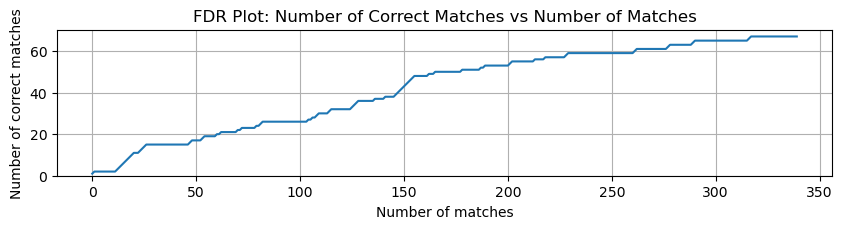

In [22]:
def match_is_correct(report_row):  # row in report.tsv
    nrp_id = report_row['NRP_ID']
    bgc_id = report_row['Genome_ID']
    nrp_class = rban_graphs_table.loc[rban_graphs_table['compound_id'] == nrp_id, 'iso_class_idx'].values[0]
    return nrp_class in bgc_to_nrp_iso_classes[bgc_id]

num_correct = 0
num_correct_array = []
for i, row in nerpa_report.iterrows():
    if match_is_correct(row):
        num_correct += 1
    num_correct_array.append(num_correct)

# q: plot num_correct_array vs i
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(len(num_correct_array)), num_correct_array)
ax.set_xlabel('Number of matches')
ax.set_ylabel('Number of correct matches')
ax.set_title('FDR Plot: Number of Correct Matches vs Number of Matches')
ax.grid()

ax.set_aspect('equal', adjustable='box')  # Ensures equal aspect ratio with flexible plot box
ax.set_ylim(bottom=0)                     # y-axis starts at 0

plt.show()
